This Notebook is created by [Moussa Jamor](https://www.github.com/jamormoussa)

Notebook link (Github): [AutoEncoders in Deep Learning](https://github.com/JamorMoussa/learn-DeepLearning/blob/main/AutoEncoders/AutoEncoders-Architecture-In-DeepLearning.ipynb)

# AutoEncoders Architecture In DeepLearning

## 1. What is AutoEncoders ?

The **AutoEncoders** are special type of neural networks used for unsupervised learning. They composed by two main components, the **Encoder** and the **Decoder**, which both are neural networks architecture. In this notebook, you will have everything need to know about **AutoEncoders**, including the theory as well as build a **AutoEncoder** model using PyTorch, the dataset we'll use is **MNIST** dataset. As well as, see What's some AutoEncoders's applications.

<center>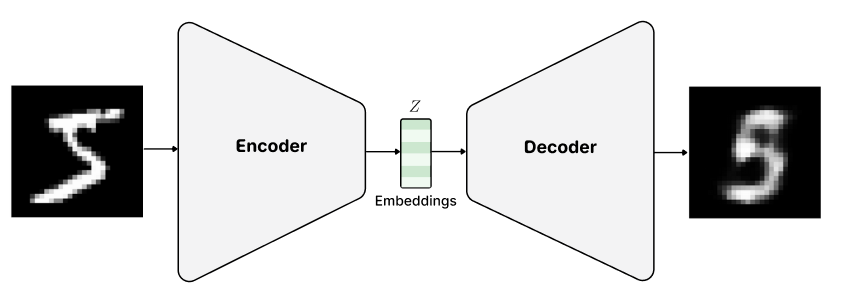

First, the **AutoEncoders** proposed by ***G. E. Hinton and R. R. Salakhutdinov*** in paper titled [Reducing the Dimensionality of Data with Neural Networks](https://sci-hub.ru/https://www.science.org/doi/10.1126/science.1127647). They proposed the AutoEncoders as ***Non-Linear generatisation of PCA***, dimentionality reduction cases. But, AutoEncoders has widely used in other applications, **Transfer Leaning**, **Generative Models**, **Anomaly Detection** and more.

## 2. Prepare the MNIST Dataset

Let's build and train our first **AutoEncoders** model. So, this section we will define the model's architecture, then we'll use the well known [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset), it's available through the `pytorchvision` library, for further information see the [torchvision MNIST documentation](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html).

Let's start by importing necessary libraries. Let's begin with `PyTorch` 🔥.

In [6]:
import torch, torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

### Define some Helping Functions

In this section, we define some helping function, that we're going to use in coming sections.

In [4]:
# define function to plot handwrite digits images 

def imshow_image(tensor: torch.Tensor) -> None:
    plt.imshow(tensor.detach().view(28, 28).numpy())

In [5]:
def plot_subplots(
    images: torch.Tensor,
) -> None:

    max_cols = 8

    fig, axes = plt.subplots(1, max_cols, figsize=(18, 2))

    num_cols = images.shape[0]

    img = images.detach().numpy()

    for col in range(num_cols):
        if col >= max_cols: break
        axes[col].imshow(img[1 + col])
    plt.show()

### Load MNSIT Dataset

To download and load the **MNSIT** dataset, we use the built-in `MNSIT` class from `torchvision.datasets`. Then sepecify some transformations by converting images to **Tensor**, using `transforms.ToTensor()`, each image is matrix of 28x28, the `nn.Flatten` transform this matrix to vector with 728 items.

In [7]:
mnist = datasets.MNIST('../files/', download=False, 
                      transform= transforms.Compose([
                          transforms.ToTensor(),
                          nn.Flatten()
                      ])
        )

After the MNSIT dataset is downloaded and loaded successflly, we can viusalize using one of helping functions `imshow_image`, which we define at the beginning.

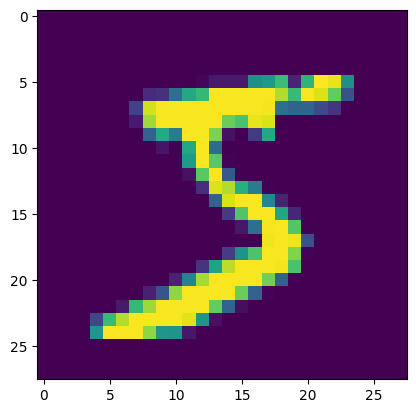

In [8]:
imshow_image(mnist[0][0])

### Split MNIST Dataset

The sections we split the MNIST dataset, into a **train** with 50000 images, and **test** with 10000 images.

In [9]:
train_data, test_data = random_split(mnist, [50000, 10000])

To train our model, we have to create a **DataLoader** for each dataset train/test. with `batch_size = 25` for training. For test dataset, we use the whole dataset.

In [10]:
batch_size = 25


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)

In [11]:
input, _ = next(iter(train_loader))

After creating the DataLoader, let's plot the 8 first hand-writing digits, using the `plot_subplots` function.

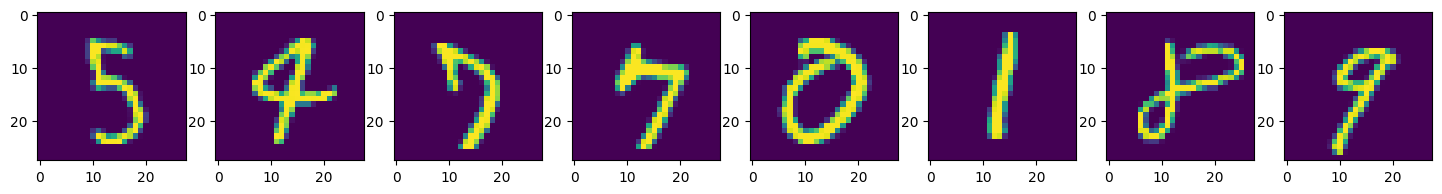

In [12]:
plot_subplots(input.squeeze(1).view(-1, 28, 28))

## 3. Build The AutoEncoders Model

This part is most exciting section, we're going to build our first **AutoEncoder** Model with **PyTorch** 🔥. As explained in the previous parts, That the **AutoEncoders** have two main components and building blocks. which are the **Encoder** and the **Decoder** component.

> **Note**:
>
> - There is no standard way to build a create a AutoEncoders architecture. Which means, we can use Vanilla MLP, ConvLayers, RNN ..., etc.
> - in our case we'll use CNN, because it performs better for images. 

Let's start with the **Encoder**. Are exciting, offcourse you are 😊. 

### Define The Encoder Model

Finally, we create a `Encoder` class, that extends for `nn.Module`, we create two main sub-models. The `conv_encoder` which is features extractor. Then, we fit the result to a `linear_encoder` that return the **Embeddings** representation of the input. At the first place, the model is initilized randomly but, it will be better and better during the training phase.

In [13]:
class Encoder(nn.Module):

    def __init__(self, input_size: int = 28*28, embeddings_size = 10) -> None:
        super(Encoder, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.Conv2d(10, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 4, 7),
            nn.Flatten(1, -1),
        )

        self.linear_encoder = nn.Sequential(
            nn.Linear(4 * 18 * 18, 128),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, embeddings_size)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = input.view(-1, 1, 28, 28)
        out = self.conv_encoder(out)
        return self.linear_encoder(out)

Let's create an instance of `Encoder` class, to see how work if we fit it, with an images as input.

In [14]:
encoder = Encoder()

In [15]:
input, _ = next(iter(train_loader))

The following code give the dense vector representation, for first images. Let's create the **Decoder** class.

In [17]:
encoder(input)[0]

tensor([-0.1382,  0.0195,  0.1412, -0.1669,  0.0075,  0.1913,  0.0990, -0.0904,
         0.0604,  0.1311], grad_fn=<SelectBackward0>)

### Define The Decoder Model

The `Decoder` class is created by extendings as well from `nn.Module`. the **Decoder** is simple the inverse architecture of the Encoder. For Convolution part, we use the `nn.ConvTranspose2d` to perform the inverse operation of `nn.Conv2d`.

In [18]:
class Decoder(nn.Module):
    def __init__(self, input_size: int = 10, embeddings_size=10):
        super(Decoder, self).__init__()
        
        self.linear_decoder = nn.Sequential(
            nn.Linear(embeddings_size, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 4 * 18 * 18),
            nn.Unflatten(1, (4, 18, 18))
        )

        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 10, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 1, 3),
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.linear_decoder(input)
        return self.conv_decoder(out.view(-1, 4, 18, 18))


Let's create a instance of `Decoder` class, then fit the model with random vector to construct an image.

In [19]:
decoder = Decoder()

In [20]:
img = decoder(torch.randn(1, 10))

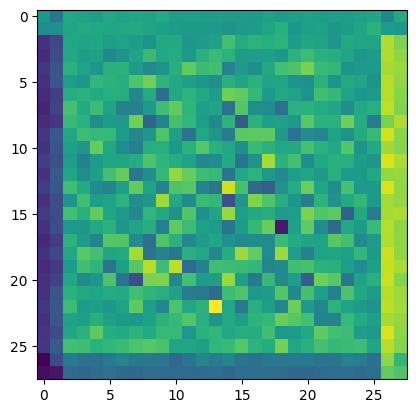

In [21]:
imshow_image(img)

## Build The AutoEncoder Model:

To create a `AutoEncoders` model, we compose the `Encoder` and the `Decoder` class.

Finally, we dit it. 

In [27]:
class AutoEncoders(nn.Module):

    def __init__(self, input_size=28*28, embeddings_size=100) -> None:
        super(AutoEncoders, self).__init__()

        self.encoder = Encoder(input_size, embeddings_size)
        self.decoder = Decoder(embeddings_size=embeddings_size)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.encoder(input)
        return self.decoder(out)

Let's create a instance of `AutoEncoders` model, and see the whole architecture.

In [35]:
model = AutoEncoders()

In [36]:
model

AutoEncoders(
  (encoder): Encoder(
    (conv_encoder): Sequential(
      (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(8, 4, kernel_size=(7, 7), stride=(1, 1))
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (linear_encoder): Sequential(
      (0): Linear(in_features=1296, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=100, bias=True)
    )
  )
  (decoder): Decoder(
    (linear_decoder): Sequential(
      (0): Linear(in_features=100, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=1296, bias=True)
      (5): Unflatten(dim=1, unflattened_size=(4, 18, 18))
    )
    (conv_decoder): Sequential(
      (0): ConvTranspose2d(4, 8, kernel_size=(7, 7), 

In [37]:
img = model(mnist[0][0])

In [38]:
img.shape

torch.Size([1, 1, 28, 28])

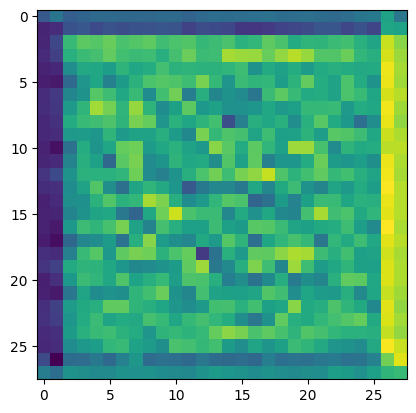

In [39]:
imshow_image(img)

## 4. Train Model 

Now, it's the time for training.

### Define Loss and Optimizer

Since, the AutoEncoders model, try to constuct the fitted image as input. So, let's consider as regression problem. that the model try to predict each pixel. Thus, `nn.MSELoss` is used as loss function to the model. 

In [40]:
criterion = nn.MSELoss()

In [41]:
# define model parameters to be updated during the back-probagation 

params_to_optimize = [
    {'params': model.encoder.parameters()},
    {'params': model.decoder.parameters()}
]

A `optim.Adam` optimizer used with a learning rate of 0.001.

In [44]:
opt = optim.Adam(params_to_optimize,lr=0.001)

### Let's Train The Model 

In [45]:
# This function is define to train the model, with MSELoss, and Adam optimizer.

def train(
    model,
    criterion,
    optimizer,
    train_loader,
    epochs=1,
    loggings: bool = True, 
    loggings_iter: int = 400,
) -> None:
    
    model.train()
    
    for epoch in range(epochs):
        
        for i, (img, _) in enumerate(train_loader):
        
            optimizer.zero_grad()
        
            gen_img = model(img)
            
            loss = criterion(gen_img.flatten(2,-1), img)
            
            loss.backward()
            
            optimizer.step()

            if i%int(loggings_iter)==0:
                print(f"Epochs: {epoch:4d} | Iteration: {i:4d}| Loss: {loss.item():4.7f}")
                print("-"*140)
                plot_subplots(img.squeeze(1).view(-1, 28, 28))
                plot_subplots(gen_img.squeeze(1).view(-1, 28, 28))

    print("-"*140)
    print("Traning is finished :) ")

Epochs:    0 | Iteration:    0| Loss: 0.1339402
--------------------------------------------------------------------------------------------------------------------------------------------


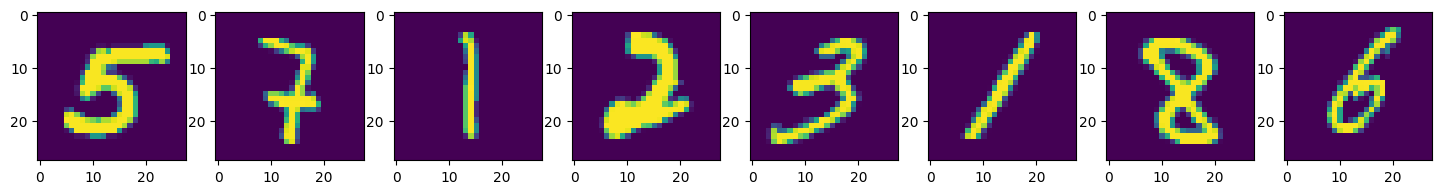

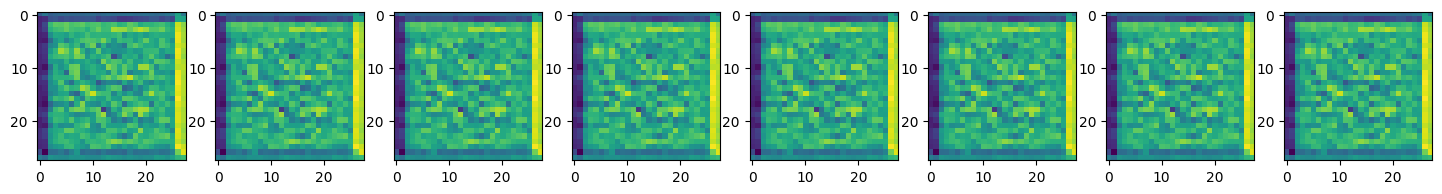

Epochs:    0 | Iteration:  400| Loss: 0.0267787
--------------------------------------------------------------------------------------------------------------------------------------------


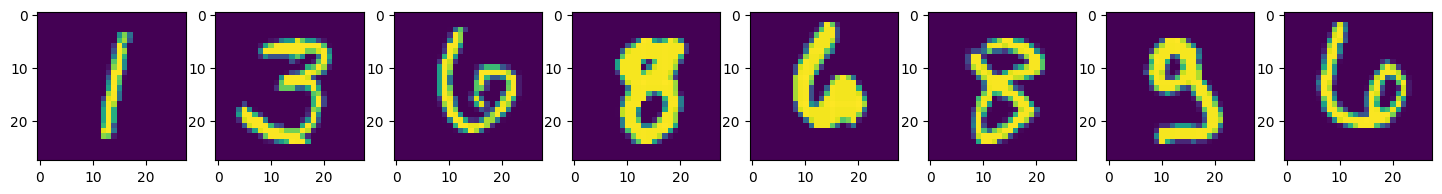

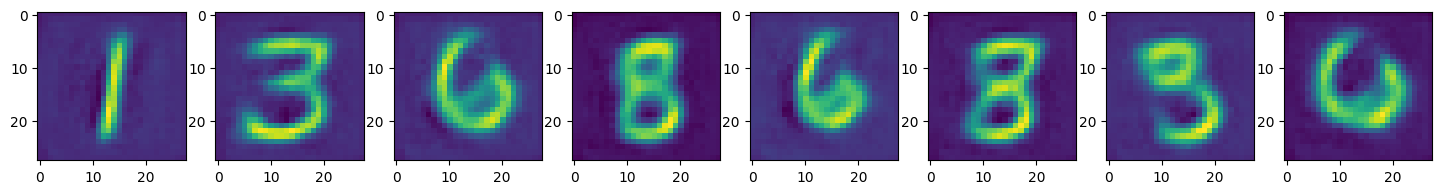

Epochs:    0 | Iteration:  800| Loss: 0.0217806
--------------------------------------------------------------------------------------------------------------------------------------------


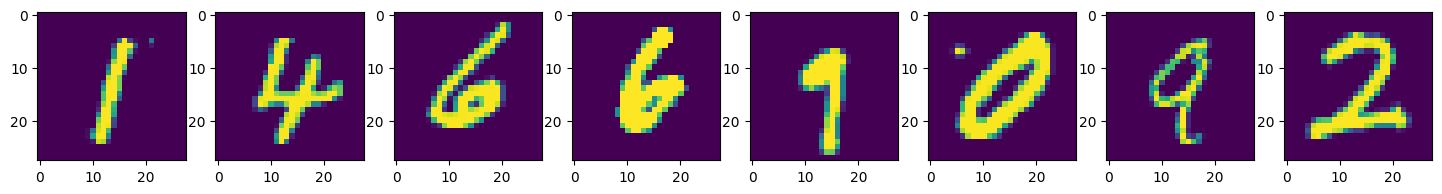

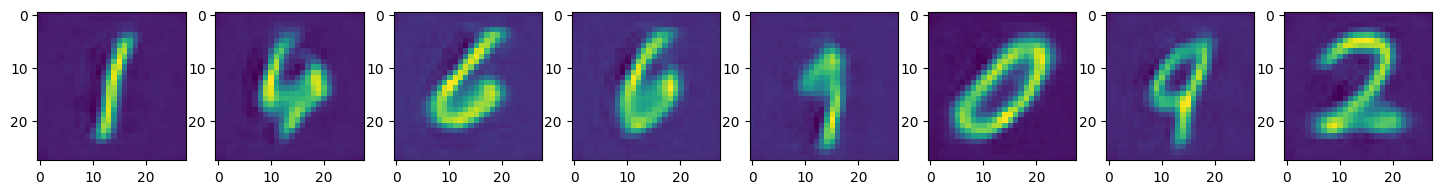

Epochs:    0 | Iteration: 1200| Loss: 0.0183262
--------------------------------------------------------------------------------------------------------------------------------------------


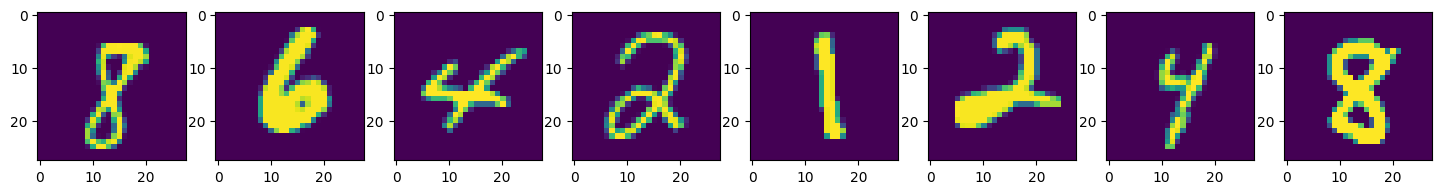

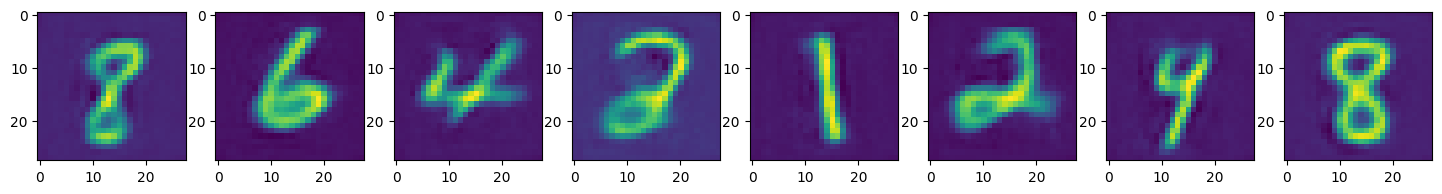

Epochs:    0 | Iteration: 1600| Loss: 0.0168445
--------------------------------------------------------------------------------------------------------------------------------------------


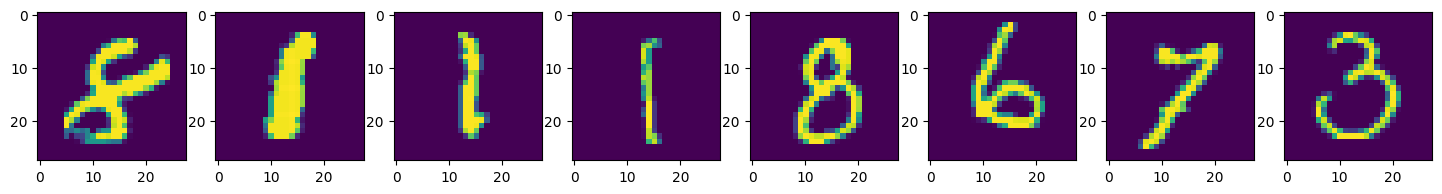

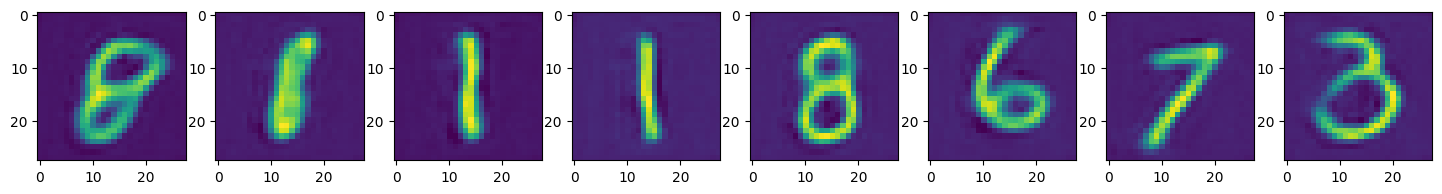

Epochs:    1 | Iteration:    0| Loss: 0.0182455
--------------------------------------------------------------------------------------------------------------------------------------------


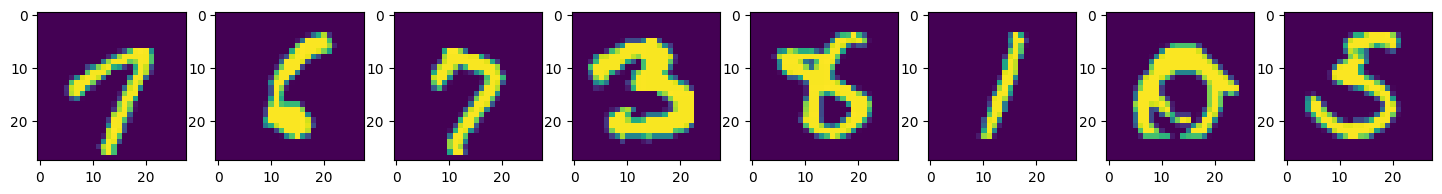

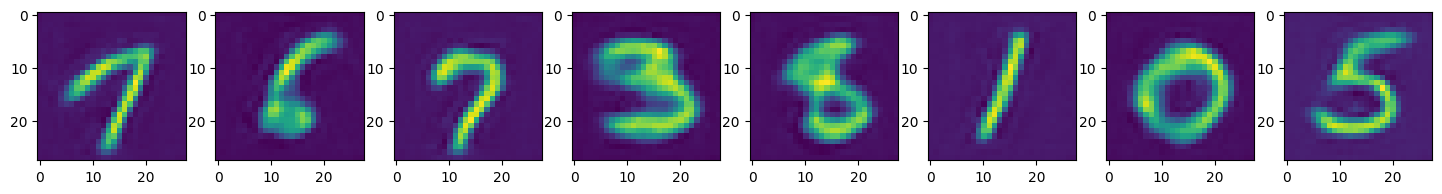

Epochs:    1 | Iteration:  400| Loss: 0.0134456
--------------------------------------------------------------------------------------------------------------------------------------------


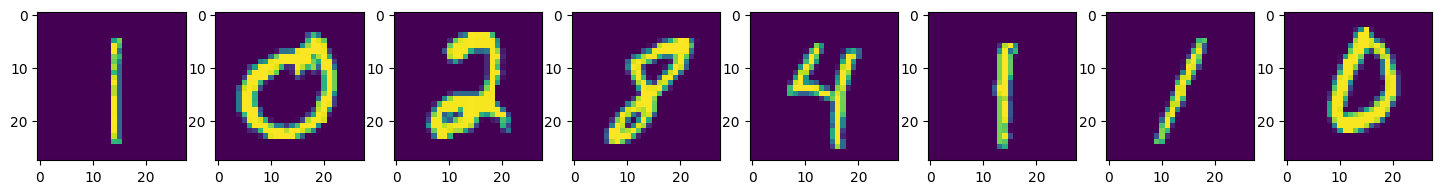

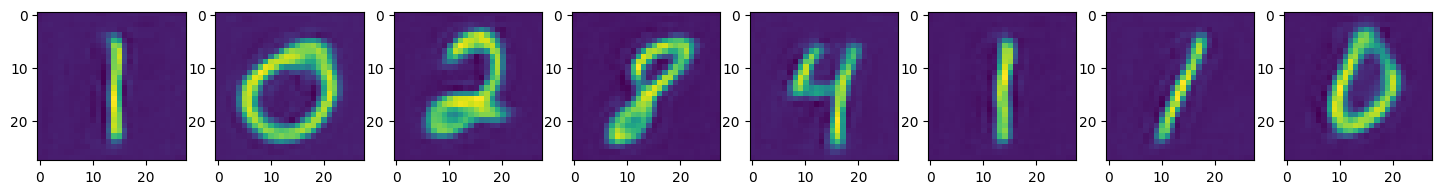

Epochs:    1 | Iteration:  800| Loss: 0.0134334
--------------------------------------------------------------------------------------------------------------------------------------------


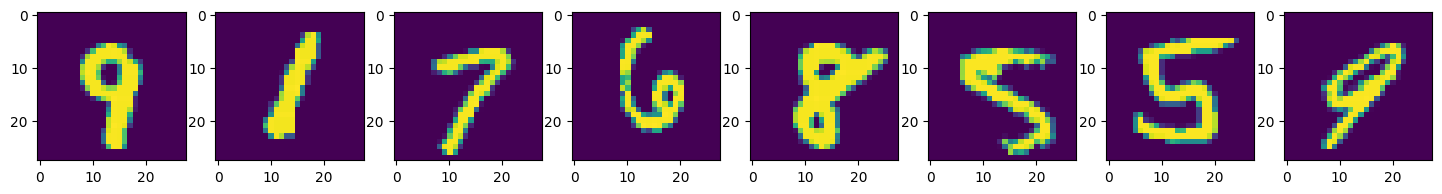

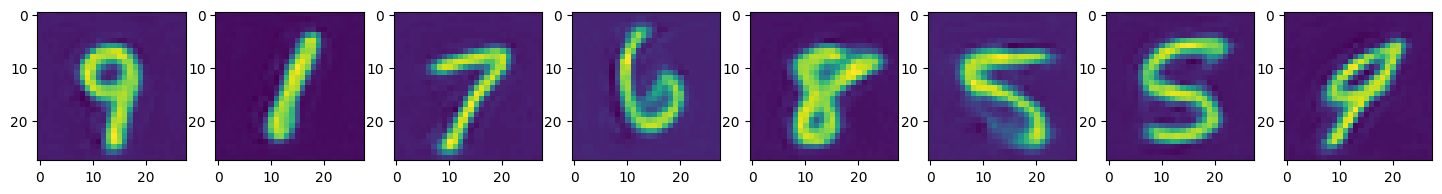

Epochs:    1 | Iteration: 1200| Loss: 0.0128348
--------------------------------------------------------------------------------------------------------------------------------------------


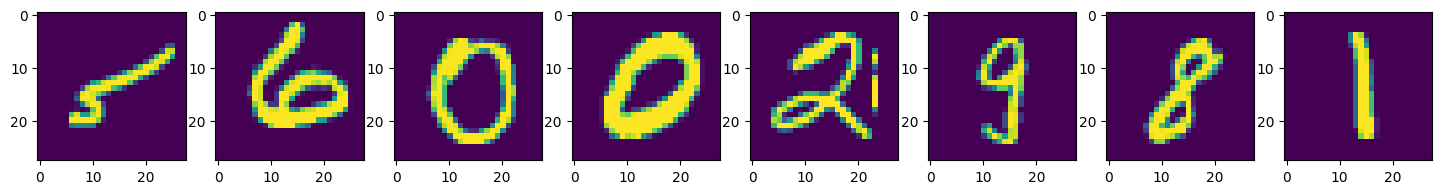

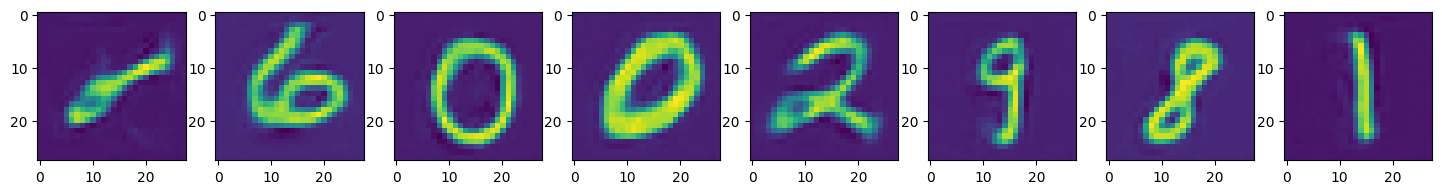

Epochs:    1 | Iteration: 1600| Loss: 0.0105310
--------------------------------------------------------------------------------------------------------------------------------------------


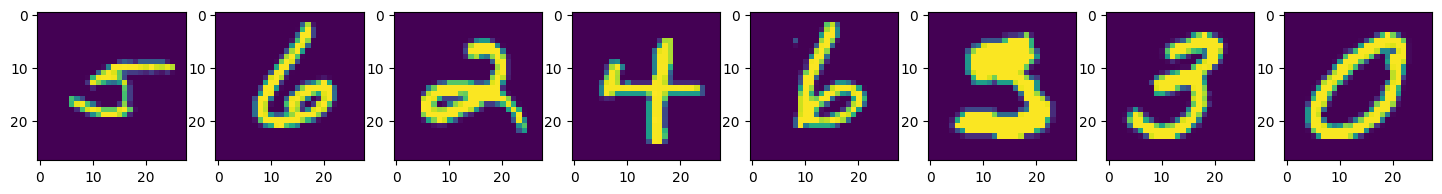

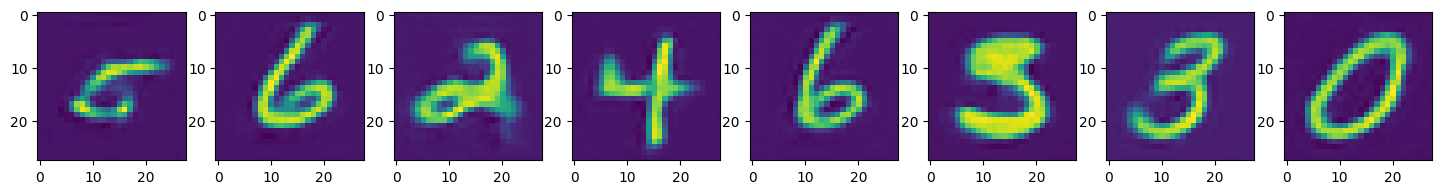

--------------------------------------------------------------------------------------------------------------------------------------------
Traning is finished :) 


In [46]:
# Let's start trainig, enjoy the show :).

train(
    model, 
    criterion, 
    optimizer=opt,
    train_loader=train_loader,
    epochs=2
)

The trainnig is finished, very nice. We can notice that model starts with noise images, but only after 400 iterations, we already indentify digits.

## 5. Save Models AutoEncoder, Encoder, Decoder

After the model trained, it's best practice to save out model, for safety reasons, ex. avoiding kernel restart in jupyter notebook and loss the model, let's save the whole model, then each components alone. 

Why? the reason, is after training, we can split the encoder from the decoder parts and each components can used in a different task. see the **Applications section** for further information.     

In [47]:
torch.save(model.state_dict(), "./models/AutoEncoders_V1.pth")

In [48]:
torch.save(model.encoder.state_dict(), "./models/Encoder_V1.pth")

In [49]:
torch.save(model.decoder.state_dict(), "./models/Decoder_V1.pth")

### Let's Load the Model

In [50]:
model = AutoEncoders()

In [53]:
model.load_state_dict(torch.load("./models/AutoEncoders_V1.pth"))

<All keys matched successfully>

In [54]:
model

AutoEncoders(
  (encoder): Encoder(
    (conv_encoder): Sequential(
      (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(8, 4, kernel_size=(7, 7), stride=(1, 1))
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (linear_encoder): Sequential(
      (0): Linear(in_features=1296, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=100, bias=True)
    )
  )
  (decoder): Decoder(
    (linear_decoder): Sequential(
      (0): Linear(in_features=100, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=1296, bias=True)
      (5): Unflatten(dim=1, unflattened_size=(4, 18, 18))
    )
    (conv_decoder): Sequential(
      (0): ConvTranspose2d(4, 8, kernel_size=(7, 7), 

## Applicattions of AutoEncoders

### Dimensionality Reduction

The **AutoEncoder** arhitecture was first proposed as ***Non-Linear generatisation of PCA*** in the paper, titled [Reducing the Dimensionality of Data with Neural Networks](https://sci-hub.ru/https://www.science.org/doi/10.1126/science.1127647). As we see in previous sections, that **AutoEncoders** comes with two networks, the **Encoder** and the **Decoder** network. The **Encoder** tends to learn the features and patters from input data, it try to transform the hight-dimension data to low-dimentional space called **Embeddings** denoted by $Z$. In other hand, the **Decoder** network, tends to restruct the data given the **Embeddings** $Z$. 

In fact, After the **AutoEncoders** model is trainned. We can use the **Encoder** newtork to get a vectors representation of a given input. This represenation can used for : 

- **Classification/Regression Cases**: The **Encoder** is also considered as *feature-extractor*, means during the back-propagation the most important features/patterns. So, we can use it as **Transfer Learning**, which means we can connect to a classifier or regressor to perform a Reression or classification for specific problem.

-  **Compute Similarity**: We can fit two samples, to the Encoder and get their representations, which are vectors, then compute a **Cosine metric** to measure similarity between these inputs.

-  **Generating new instances/ Data Augmentation**: After the model is trained, we can use **Decoder** to generate new instances for us, a use case if you have not must data using this techniques, is powerful becuase it learn the distribution during the training. 

In this section, we're going to use the pre-trainned AutoEncoder model, gotten in previous section, to perform classification (regression), and measure similarity between MNSIT images. 

#### MNIST Classification  

In [56]:
# TODO: build a model to classify mnist digits and use the encoder part from pre-trainned autoencoders model. 

#### Images Similarity

In [57]:
# TODO: compute a images similrity using the cosine metric.

# - choose a random images and compute the similarity between these images.
# - 

### Generative modeling & Data Augmentation

In [56]:
# TODO: generate some new instance images, with the decoder block

# - compute the (mean, std) for each class
# - plot the distribution of each embeddings.
# - use these information to generate new instances

---

## References

- **AutoEncoders** Original Paper by ***G. E. Hinton and R. R. Salakhutdinov*** [Reducing the Dimensionality of Data with Neural Networks](https://sci-hub.ru/https://www.science.org/doi/10.1126/science.1127647)